 # Fetch Rewards - Data Challenge - Frankenstein Hidden Sentences
 
 **Michael Kranz**


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from spacy.lang.en import English # Create the nlp object
import spacy
from spacy.tokens import Doc,Span,Token
from collections import Counter

In [4]:
#hidden sentence bookend names and symbols
bookend_symbols = {
    "ASTERIX":'*',
    "LESSTHAN":'<',
    "DOLLAR":'$',
    "HASHTAG":'#'
}

#to filter for bag of words:
bookend_chars = list(bookend_symbols.values())
punctuation_chars = ['?','!','.',',',';'] 
other_chars = ['\n','-']
bag_of_words_chars_to_filter = bookend_chars + punctuation_chars + other_chars

## define functions to extend the Doc class properties and methods

In [15]:
def get_bookend_spans(doc,bookend_key):
    '''
    identifies bookend spans and does two things for downstream tasks:
    1. create booleans for bookend span and type of bookend span
    2. save the span objects of each bookend type in a list
    '''
    #initiate dict to store bookend spans in
    bookend_spans = {name:[] for name in bookend_key.keys()}
    
    #get spans for each type of bookend
    for name,symbol in bookend_key.items():
        span_list_tmp = [] #initiate container to store spans
        for match in re.finditer(f"\{symbol}.*\{symbol}",doc.text):
            match_indices = match.span()
            start,end = match_indices
            
            #Create a `Span` object from the slice `doc.text[start : end]`.
            span = doc.char_span(start, end,label=name+str(start))
            span._.bookend_name = name
            #span_list_tmp.append(span[1:-1]) #exclude bookends (end index is exclusive)
            span_list_tmp.append(span)
            
            #label tokens within span for easier reference in doc object 
            #(ie token --> doc based on span membership)
            for token in span:
                token._.bookend_name = name
                if token.text==symbol:
                    token._.is_bookend = True
                else:
                    token._.is_in_bookend = True
            
        bookend_spans[name] = span_list_tmp 
    return bookend_spans

def remove_bookend_tokens_from_text(doc):
    '''
    Removes the 4 hidden sentences from the original text file
    
    returns the text attribute with removal.
    
    TODO: save a clean version of the first chapter of Frankenstein to a text file 
    (call it 'Clean_Frankenstein.txt')
    '''
    text_list_no_book_ends = [
        token.text+token.whitespace_
        for token in doc 
        if (not token._.is_bookend 
             and not token._.is_in_bookend)
    ]
    
    return ''.join(text_list_no_book_ends)


def make_bag_of_words(doc):
    '''
    Stores all distinct words in the text in a Counter dictionary 
    and keeps track of the word counts 
    (make sure to strip all punctuation and lower the case of the words)
    
    - assumes "punctuation" entails both classic punctuation characters and bookend characters
    - alternatively, the token.is_punct_ attribute could be used (and may be more efficient)
    -lemmatization,filtering stop words left out to follow data challenge guideline of 
     punctuation and lowercase.
    
    TODO: Save the distinct word dictionary as a JSON file (call it 'word_count_dict.json')
    '''
    text_tokenized = [
        token.text.lower()
        for token in doc
        if (token.text 
            not in bag_of_words_chars_to_filter)
    ]
    return Counter(text_tokenized)

def plot_word_length(doc):
    
    '''
    Plot a histogram of the count of words by word length 
    for all words in the document
    '''
    
    #get the word counts for each word length
    word_lengths = [
        len(token.text)
        for token in doc
        if (token.text 
            not in bag_of_words_chars_to_filter)
    ]
    bag_of_lengths = (
        pd.Series(Counter(word_lengths))
        .sort_index()
        .reset_index()
    )
    bag_of_lengths.columns = ['word_length','word_count']
    
    #plot the word length by the word count for each length
    fig_word_count_by_word_length = bag_of_lengths.plot(
        kind='bar',
        x='word_length',y='word_count',
        legend=None
    )
    plt.title("Count of Words by Word Length ")
    plt.xlabel("Word Length")
    plt.ylabel("Number of Words (Count)\nat a Word Length")
    
    return fig_word_count_by_word_length

## Add methods and properties to the spacy class objects

In [16]:
#search/manipulation tasks with bookends
Doc.set_extension('bookend_spans',method=get_bookend_spans,force=True) #put labels in for spans and tokesn
Doc.set_extension('text_with_no_bookends',method=remove_bookend_tokens_from_text,force=True)
#summary tasks
Doc.set_extension('bag_of_words',getter=make_bag_of_words,force=True)
Doc.set_extension('word_length_plot',getter=plot_word_length,force=True)
#span & token bookend properties populated by doc bookend tasks
Span.set_extension('bookend_name',getter=lambda span,name: name,force=True) #spacy recommends getter for Spans
Token.set_extension('bookend_name',default=None,force=True)
Token.set_extension('is_in_bookend',default=False,force=True) #for tokens within bookends
Token.set_extension('is_bookend',default=False,force=True) #for bookend tokens

## Frankenstein Chapter 1 copied from the Fetch Data Challenge word document

In [17]:
text_str = '''
Letter 1
To Mrs. Saville, England. <Scrapers<
St. Petersburgh, Dec. 11th, 17—.
You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. I arrived here yesterday, and my first task is to assure my $You$ dear sister of my welfare and increasing confidence in the success of my undertaking.
I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. Do you understand this feeling? This breeze, which has travelled from the regions towards which I am advancing, gives me a foretaste of those icy climes. Inspirited by this wind of promise, my daydreams become more fervent and vivid. I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents $are$ itself to my imagination as the region of beauty and delight. There, Margaret, the sun is for ever visible, its broad disk just skirting the horizon and diffusing a perpetual splendour. There—for with your leave, my sister, I will put some trust in preceding navigators—there snow and frost are banished; and, sailing over a calm sea, we may be wafted to a land surpassing *You're* in wonders and in beauty every region hitherto discovered on the habitable globe. Its productions and features may be without example, as the phenomena of the heavenly bodies undoubtedly are in those undiscovered solitudes. What may not be expected in a country of eternal light? I may there discover the wondrous power which attracts the needle and may regulate a thousand celestial observations that require only this voyage to render their seeming eccentricities consistent for ever. I shall satiate my ardent curiosity with the sight of a part of the world never before visited, and may tread a land never before imprinted by the foot of man. These are my enticements, and they are sufficient to conquer all fear of danger or death and to induce me to commence this laborious voyage with the joy a child feels when he embarks in a little boat, with his holiday mates, on an expedition of discovery up his native river. But supposing all these conjectures to be false, you cannot contest the inestimable benefit which I shall confer on all mankind, to the last generation, by discovering a passage near the pole to those countries, to reach which at present so many months are requisite; or by ascertaining the secret of the magnet, which, if at all possible, can only be effected by an undertaking such as mine.
These reflections have dispelled the agitation with which I began my letter, and I feel my heart glow with an enthusiasm which elevates me to heaven, for nothing contributes so much to tranquillise the mind as a steady purpose—a point on which the soul may fix its intellectual eye. This expedition has been the favourite dream of my early years. #Found# I have read with ardour the accounts of the various voyages which have been made in the prospect of arriving at the North Pacific Ocean through the seas which surround the pole. You may remember that a history of all the voyages made for purposes of discovery composed the whole of our good Uncle Thomas’ library. My education was neglected, yet I was passionately fond of reading. These volumes were my study day and night, and my familiarity with them increased that regret which I had felt, as a child, on learning that my father’s dying injunction had forbidden my uncle to allow me to embark in a seafaring life.
These visions faded when I perused, for the first time, those poets whose effusions entranced my soul and lifted it to heaven. I also became a poet and for one year lived in a paradise of my own creation; I imagined that I also might obtain a niche in the temple where the names of Homer and Shakespeare are consecrated. You are well acquainted with *killin* my failure and how heavily I bore the disappointment. But just at that time I inherited the fortune of my cousin, and my thoughts were turned into the channel of their earlier bent.
Six years have passed since I resolved on my present undertaking. I can, even now, remember the hour from which I dedicated myself to this great enterprise. I commenced by inuring my body to hardship. I accompanied the whale-fishers on several expeditions to the North Sea; I voluntarily endured cold, famine, thirst, and want of sleep; I often #another# worked harder than the common sailors during the day and devoted my nights to the study of mathematics, the theory of medicine, and those branches of physical science from which a naval adventurer might derive the greatest practical advantage. Twice I actually hired myself as an under-mate in a Greenland whaler, and acquitted myself to admiration. I must own I felt a little proud when my captain offered me the second dignity in the vessel and entreated me to remain with the greatest earnestness, so valuable did he consider my services.
And now, dear <for< Margaret, do I not deserve to accomplish some great purpose? My life might have been passed in ease and luxury, but I preferred glory to every enticement that wealth placed in my path. Oh, that some encouraging voice would answer in the affirmative! My courage and my resolution is firm; but my hopes fluctuate, and my spirits are often depressed. I am about to proceed on a long and difficult voyage, the emergencies of which will demand all my fortitude: I am required not only to raise the spirits of others, but sometimes to sustain my own, when theirs are failing.
This is the most favourable period for travelling in Russia. They fly quickly over the snow in their sledges; the motion is pleasant, and, in my opinion, far more agreeable than that of an English stagecoach. The $amazing!$ cold is not excessive, if you are wrapped in furs—a dress which I have already adopted, for there is a great difference between walking the deck and remaining seated motionless for hours, when no exercise prevents the blood from actually freezing in your veins. I have no ambition to lose my life on the post-road between St. Petersburgh and Archangel. <the<
I shall depart for the latter town in a fortnight or three weeks; and my intention is to hire a ship there, which can easily be done by paying the insurance for the owner, *it!* and to engage as many sailors as I think necessary among those who are accustomed to the whale-fishing. I do not intend to sail until the month of June; and when shall I return? Ah, dear sister, how can I answer this question? If I succeed, many, many months, perhaps years, will pass before you and I may meet. If I fail, you will see me again soon, or never.
Farewell, my dear, excellent Margaret. Heaven #one!# shower down blessings on you, and save me, that I may again and again testify my gratitude for all your love and kindness.
Your affectionate brother,
R. Walton<win!<
'''

## Create doc object and complete data challenge tasks with custom spacy functions/methods

In [18]:
nlp = English()

In [19]:
doc = nlp.make_doc(text_str)

- **Store all distinct words in the text in a dictionary and keep track of the word counts (make sure to strip all punctuation and lower the case of the words**
- **Save the distinct word dictionary as a JSON file (call it 'word_count_dict.json')**

In [20]:
bag_of_words = doc._.bag_of_words
#save to json file
(
    pd.Series(bag_of_words)
    .sort_values(ascending=False)
    .to_json('word_count_dict.json')
)

- **Find 4 hidden sentences in the text (they will be words bookended by special symbols)**
- **Save the 4 hidden sentences together as a list of lists, then join them and print them with a for loop**

In [23]:
bookend_spans = doc._.bookend_spans(bookend_symbols) #get bookend spans
bookend_sentences = [ #list of lists format
    ' '.join(x.text[1:-1] for x in span_list) #get rid of bookends in spans
    for name,span_list in bookend_spans.items()
]
for sentence in bookend_sentences:
    print(sentence)

You're killin it!
Scrapers for the win!
You are amazing!
Found another one!


- **Remove the 4 hidden sentences from the original text file and save a clean version of the first chapter of Frankenstein to a text file (call it 'Clean_Frankenstein.txt')**

In [37]:
clean_text = doc._.text_with_no_bookends()
#save text to file
with open("Clean_Frankenstein.txt","w") as file:
    file.write(clean_text)

- **Plot a histogram of the count of words by word length for all words in the document**

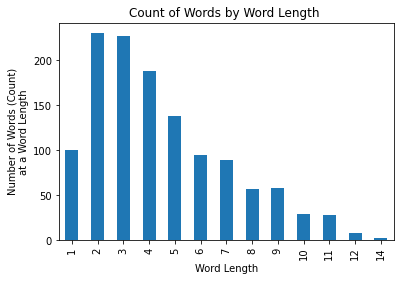

In [58]:
word_length_plot = doc._.word_length_plot

 ## Next Steps
 
 - From this prototype, the next step is to make a ScraperClass 
     - ie automate the steps at the end either by: 
         1. adding to the spacy nlp object pipeline directly 
         2. creating a wrapper class that performs plot/post processing steps on top of the Doc.